# 1.4 State sequence variability

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import pickle

from one.api import ONE
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, rescale_sequence
from plotting_functions import plot_binned_sequence
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

## Parameters

In [4]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix +  'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [6]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

## Trial epoch barcoding

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:740: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/Models

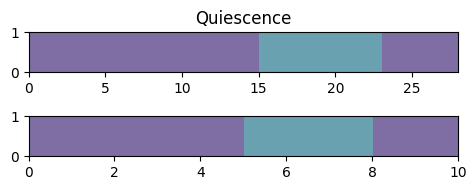

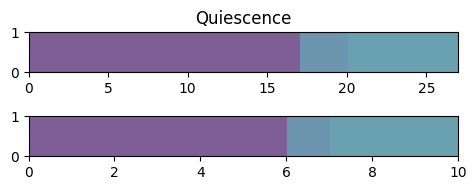

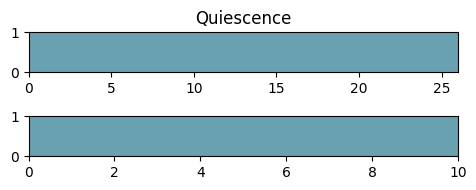

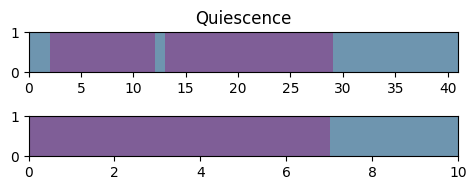

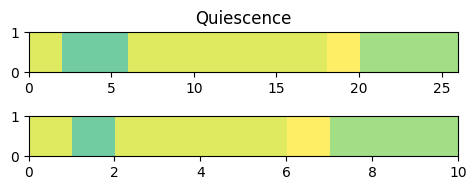

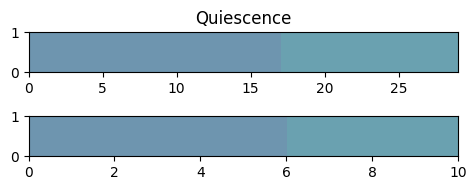

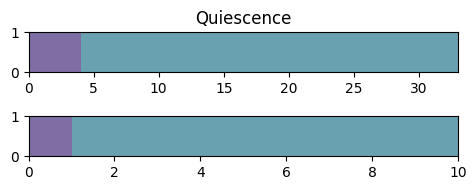

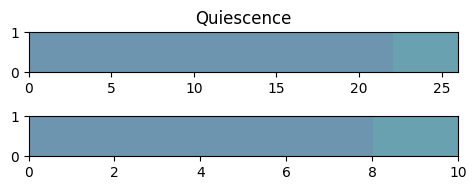

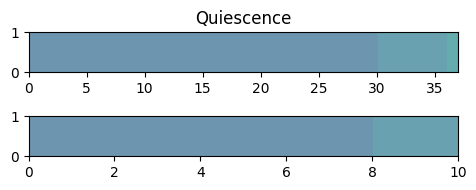

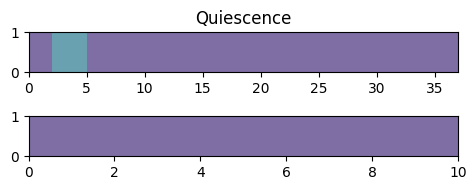

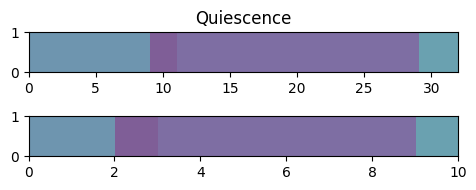

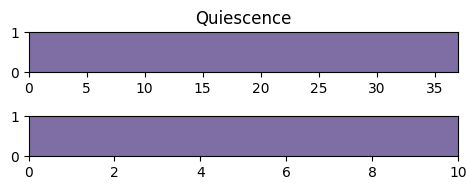

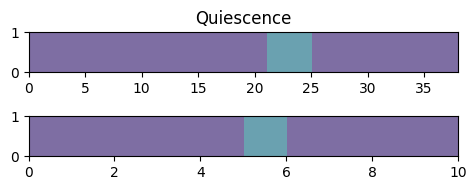

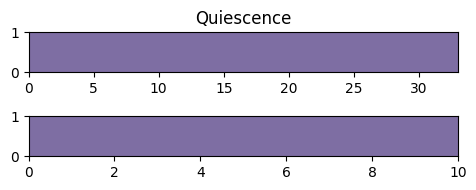

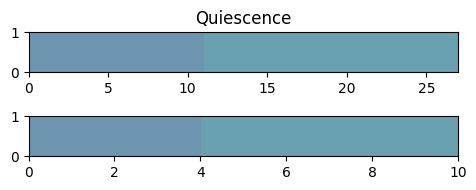

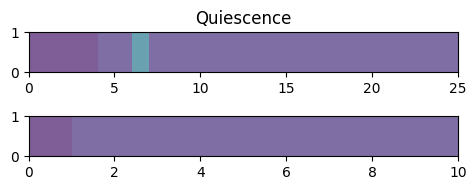

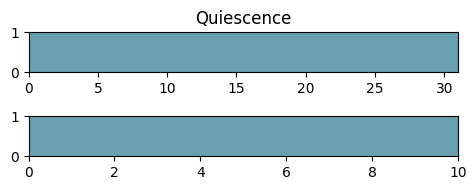

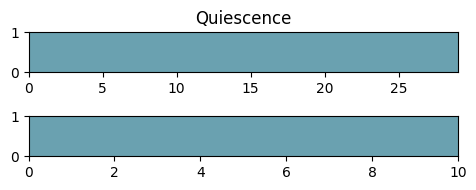

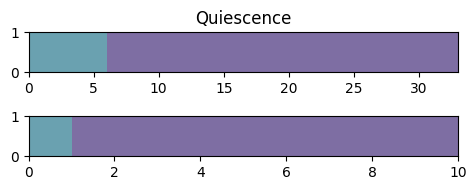

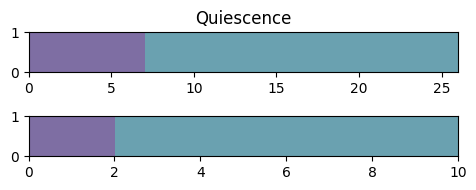

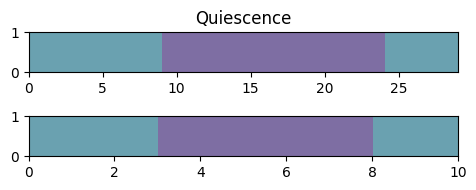

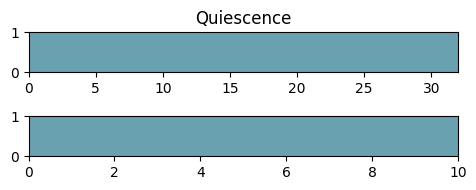

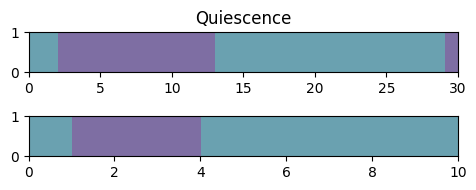

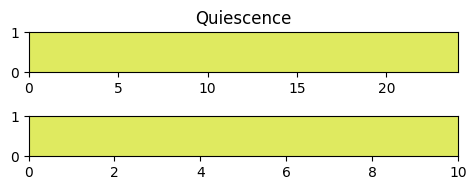

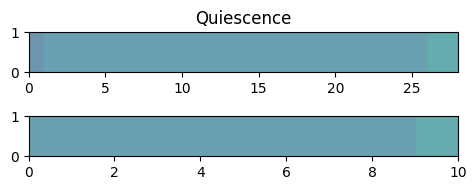

In [15]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
# trial_type_agg = ['correct_str']

plot = True
target_length = 10

all_sequences = pd.DataFrame(columns=['mouse_name', 'trial_type', 'broader_label', 'binned_sequence'])
for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_file['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'most_likely_states']

    df_grouped = states_df.groupby(vars[:-1])['most_likely_states'].apply(list).reset_index()
    df_grouped.rename(columns={'most_likely_states': 'sequence'}, inplace=True)
    df_grouped['binned_sequence'] = df_grouped['sequence'].apply(lambda seq: rescale_sequence(seq, target_length))  # New function removed NaNs
    
    if plot == True:
        states_to_append = np.arange(0, num_states)
        for i in range(100):
            if df_grouped['broader_label'][i] == 'Quiescence':
                plot_binned_sequence(df_grouped, i, states_to_append, 'viridis')

    # df_grouped['y'] = df_grouped['trial_type'] + df_grouped['broader_label']
    
    all_sequences = pd.concat([all_sequences, df_grouped[['mouse_name', 'sample', 'trial_type', 'broader_label', 'binned_sequence']]], ignore_index=True)
    

In [8]:
del states_file

In [7]:
filename = "epoch_sequences_10_"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
file_format = 'pickle'
script_name = '1.4_state_seq_var.ipynb'
metadata = save_and_log(all_sequences, filename, file_format, save_path, script_name)

### Load data directly

In [7]:
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))


In [8]:
num_samples = 100

In [7]:
all_sequences['type'] = all_sequences['trial_type'].str.split().str[:2].str.join('')
# all_sequences['type'] = all_sequences['trial_type'].copy()
all_sequences['y'] = all_sequences['type'] + all_sequences['broader_label']
# all_sequences['y'] = all_sequences['broader_label']

sequence_types = all_sequences['y'].unique()
len_matrix = 4950

all_cos_sim = pd.DataFrame(columns=['epoch', 'type', 'cos_sim', 'shuffle'], index=range(len(sequence_types)*len_matrix))
for s, stype in enumerate(sequence_types):
    use_data = all_sequences.loc[all_sequences['y']==stype]
    shuffle_data = all_sequences.copy()
    
    X = np.vstack(use_data['binned_sequence'].apply(lambda x: np.array(x)).values)
    X_final = X[~np.isnan(X).any(axis=1), :].astype(int)

    X_shuffle = np.vstack(shuffle_data['binned_sequence'].apply(lambda x: np.array(x)).values)
    X_final_shuffle = X_shuffle[~np.isnan(X_shuffle).any(axis=1), :].astype(int)
    
    if len(X_final) > num_samples:
        # Downsample
        indices = np.random.choice(X_final.shape[0], num_samples, replace=False)  # Random indices
        subsampled_matrix = X_final[indices]
        indices_shuffle = np.random.choice(X_final_shuffle.shape[0], num_samples, replace=False)  # Random indices
        subsampled_matrix_shuffle = X_final_shuffle[indices_shuffle]

        # cos_sim_matrix = cosine_similarity(subsampled_matrix.astype(np.uint8))
        # cos_sim_matrix_shuffle = cosine_similarity(subsampled_matrix_shuffle.astype(np.uint8))
        cos_sim_matrix = distance.pdist(subsampled_matrix.astype(np.uint8), metric='hamming')
        cos_sim_matrix_shuffle = distance.pdist(subsampled_matrix_shuffle.astype(np.uint8), metric='hamming')
        
        # plt.imshow(cos_sim_matrix)
        # plt.title(stype)
        # plt.show()
        # plt.imshow(cos_sim_matrix_shuffle)
        # plt.title(stype)
        # plt.show()
        
        # Save results
        all_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = list(use_data.loc[use_data['y']==stype, 'broader_label'])[0]
        all_cos_sim['type'][s*len_matrix:(s+1)*len_matrix] = list(use_data.loc[use_data['y']==stype, 'type'])[0]
        all_cos_sim['cos_sim'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix
        all_cos_sim['shuffle'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix_shuffle
    
        # del use_data, X, X_final, X_shuffle, X_final_shuffle, subsampled_matrix,  subsampled_matrix_shuffle, cos_sim_matrix, cos_sim_matrix_shuffle

/tmp/ipykernel_23001/4032461618.py:40: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = list(use_data.loc[use_data['y']==stype, 'broader_label'])[0]
/tmp/ipykernel_23001/4032461618.py:41: Fu

/tmp/ipykernel_23001/3062500038.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='epoch', y='value', hue='Dataset', data=new_df, color='grey',


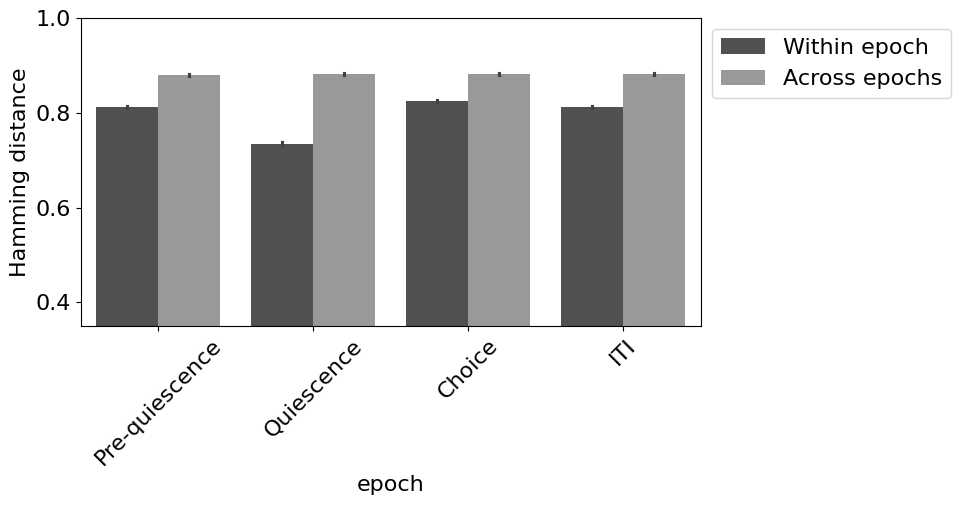

In [29]:

plt.rcParams.update({'font.size': 16})
new_df = pd.melt(all_cos_sim, id_vars=['type', 'epoch'], value_vars=['cos_sim', 'shuffle'])
new_df = new_df.rename(columns={"variable": "Dataset"})
new_df.loc[new_df['Dataset']=='cos_sim', 'Dataset'] = 'Within epoch'
new_df.loc[new_df['Dataset']=='shuffle', 'Dataset'] = 'Across epochs'

plt.figure(figsize=[8, 4])
sns.barplot(x='epoch', y='value', hue='Dataset', data=new_df, color='grey', 
            order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], alpha=.8)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.ylabel('Hamming distance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

### Calculate per animal

In [11]:
all_sequences['type'] = all_sequences['trial_type'].str.split().str[:2].str.join('')
all_sequences['type'] = all_sequences['trial_type'].str.split().str[:1].str.join('')
all_sequences['y'] = all_sequences['type'] + all_sequences['broader_label']
all_sequences['y'] = all_sequences['broader_label'] 

use_sequences = all_sequences.copy() #.loc[all_sequences['type']=='correct']

num_samples = 100
len_matrix = 4950

sequence_types = use_sequences['y'].unique()
unique_mice = use_sequences['mouse_name'].unique()

cos_sim = pd.DataFrame(columns=['mouse_name', 'epoch', 'cos_sim', 'shuffle'])

for s, stype in enumerate(sequence_types):
    use_data = use_sequences.loc[use_sequences['y']==stype]
    
    mouse_cos_sim = pd.DataFrame(columns=['mouse_name', 'epoch', 'cos_sim', 
                                          'shuffle'], index=range(len(sequence_types)*len_matrix))
    for m, mouse in enumerate(unique_mice):
        mouse_data = use_data.loc[use_data['mouse_name']==mouse]
        shuffle_mouse = use_data.copy()
        
        X = np.vstack(mouse_data['binned_sequence'].apply(lambda x: np.array(x)).values)
        X_final = X[~np.isnan(X).any(axis=1), :].astype(int)
        X_shuffle = np.vstack(shuffle_mouse['binned_sequence'].apply(lambda x: np.array(x)).values)
        X_shuffle_final = X_shuffle[~np.isnan(X_shuffle).any(axis=1), :].astype(int)
        
        if len(X_final) > num_samples:
            # Downsample
            indices = np.random.choice(X_final.shape[0], num_samples, replace=False)  # Random indices
            subsampled_matrix = X_final[indices]
            indices_shuffle = np.random.choice(X_shuffle_final.shape[0], num_samples, replace=False)  # Random indices
            subsampled_matrix_shuffle = X_shuffle_final[indices_shuffle]
                            
            # cos_sim_matrix = cosine_similarity(subsampled_matrix.astype(np.uint8))
            # cos_sim_matrix_shuffle = cosine_similarity(subsampled_matrix_shuffle.astype(np.uint8))
            cos_sim_matrix = distance.pdist(subsampled_matrix.astype(np.uint8), metric='hamming')
            cos_sim_matrix_shuffle = distance.pdist(subsampled_matrix_shuffle.astype(np.uint8), metric='hamming')
            
            # Save results
            mouse_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = stype 
            mouse_cos_sim['mouse_name'][s*len_matrix:(s+1)*len_matrix] = mouse
            mouse_cos_sim['cos_sim'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix
            mouse_cos_sim['shuffle'][s*len_matrix:(s+1)*len_matrix] = cos_sim_matrix_shuffle
            
            
            cos_sim = pd.concat([cos_sim, mouse_cos_sim], ignore_index=True)
                
        else:
            print(mouse)

/tmp/ipykernel_23001/1824349412.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mouse_cos_sim['epoch'][s*len_matrix:(s+1)*len_matrix] = stype
/tmp/ipykernel_23001/1824349412.py:44: FutureWarning: ChainedAssignmentError: behaviour will c

In [13]:
new_df = pd.melt(cos_sim, id_vars=['mouse_name', 'epoch'], value_vars=['cos_sim', 'shuffle'])
grouped_df = pd.DataFrame(new_df.groupby(['mouse_name', 'epoch', 'variable'])['value'].mean()).reset_index()


/tmp/ipykernel_23001/2940803720.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:Grey'` for the same effect.

  sns.barplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey',


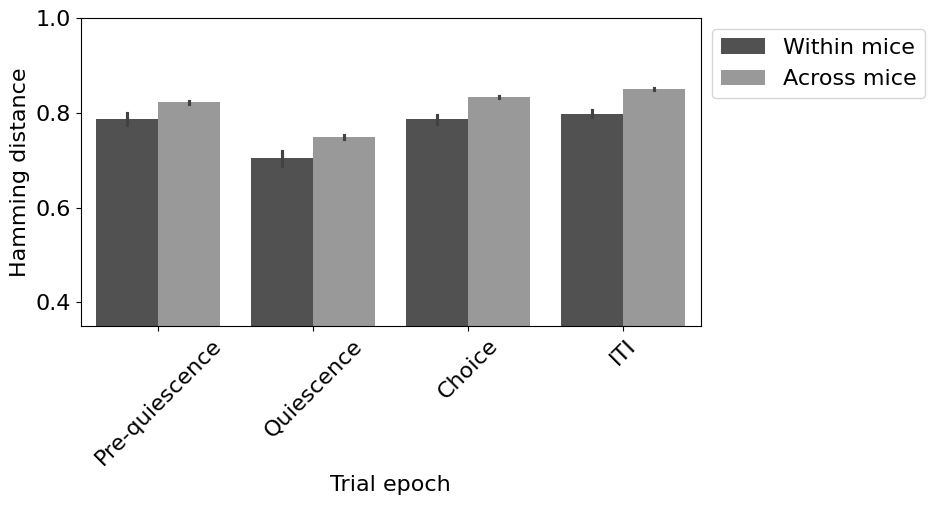

In [26]:
plt.rcParams.update({'font.size': 16})
grouped_df = grouped_df.rename(columns={"variable": "Dataset"})
grouped_df.loc[grouped_df['Dataset']=='cos_sim', 'Dataset'] = 'Within mice'
grouped_df.loc[grouped_df['Dataset']=='shuffle', 'Dataset'] = 'Across mice'

plt.figure(figsize=[8, 4])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
# sns.violinplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey', alpha=.8)
sns.barplot(x='epoch', y='value', hue='Dataset', data=grouped_df, color='Grey', 
            order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], alpha=.8)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(87.72222222222221, 0.5, 'Hamming distance')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 27.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


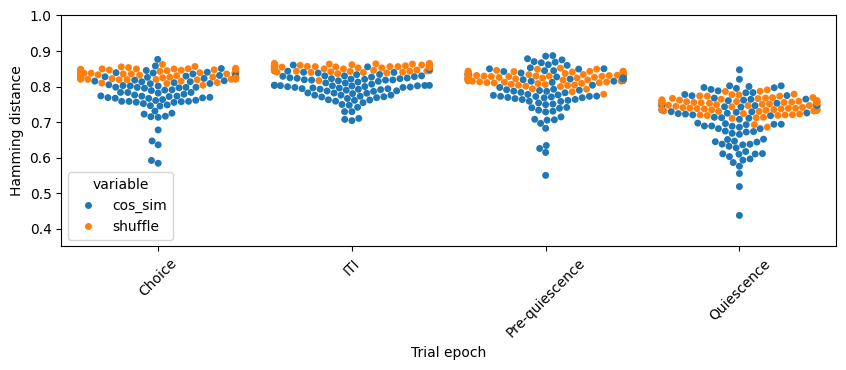

In [25]:

plt.figure(figsize=[10, 3])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
sns.swarmplot(x='epoch', y='value', hue='variable', data=grouped_df)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

Text(0, 0.5, 'Hamming distance')

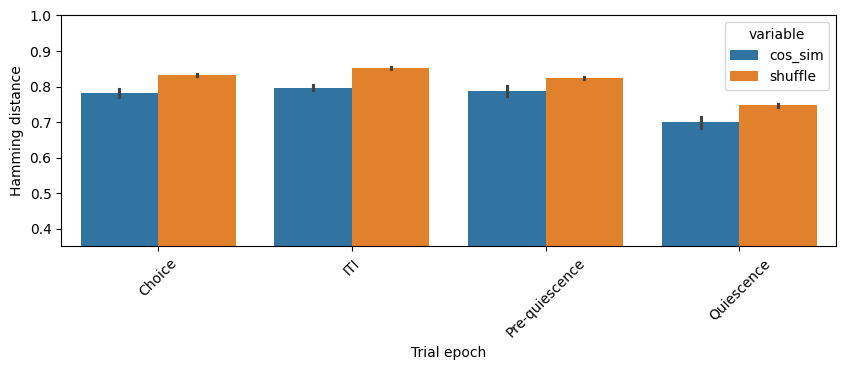

In [26]:

plt.figure(figsize=[10, 3])
# sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
sns.barplot(x='epoch', y='value', hue='variable', data=grouped_df)
plt.xticks(rotation=45)
plt.ylim([.35, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

Text(112.72222222222221, 0.5, 'Hamming distance')

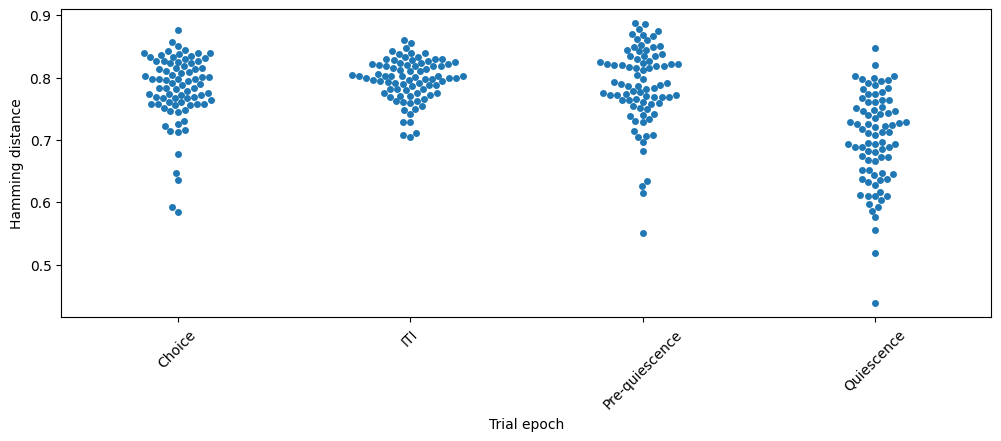

In [27]:

plt.figure(figsize=[12, 4])
sns.swarmplot(x='epoch', y='value',  data=grouped_df.loc[grouped_df['variable']=='cos_sim'])
plt.xticks(rotation=45)
# plt.ylim([.6, 1])
plt.xlabel('Trial epoch')
plt.ylabel('Hamming distance')

([0, 1, 2, 3],
 [Text(0, 0, 'Choice'),
  Text(1, 0, 'ITI'),
  Text(2, 0, 'Pre-quiescence'),
  Text(3, 0, 'Quiescence')])

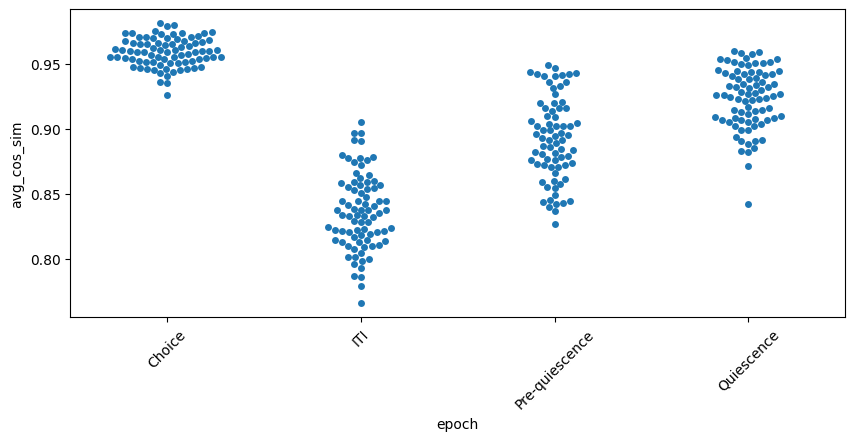

In [75]:
plt.figure(figsize=[10, 4])
sns.swarmplot(x='epoch', y='avg_cos_sim', data=cos_sim)
plt.xticks(rotation=45)
# plt.ylim([.6, 1])